In [1]:
import numpy as np
import yaml
import shutil
import uuid
from tensorflow.keras import backend as K
from nn_tools import read_count
import tensorflow as tf
from data_bank import data_selector
import model_builders as mb
import os
from os.path import join
import matplotlib.pyplot as plt
import sys
from adversarial_attacks.spsa import spsa, spsa_T1

In [2]:
def create_adversarial_pattern(input_image, input_label, pretrained_model):

    loss_object = tf.keras.losses.binary_crossentropy
    with tf.GradientTape() as tape:
        image = np.expand_dims(input_image, axis = 0)
        image = tf.convert_to_tensor(image)
        tape.watch(image)
        prediction = pretrained_model(image)
        loss = loss_object(input_label, prediction)
    gradient =  tape.gradient(loss,image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:

    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

    configfile = 'config_adv.yml'
    with open(configfile) as ymlfile:
        cgf = yaml.load(ymlfile, Loader =yaml.SafeLoader)

 # Set up computational resource 
    use_gpu = cgf['COMPUTER_SETUP']['use_gpu']
    print("""\nCOMPUTER SETUP
Use gpu: {}""".format(use_gpu))
    if use_gpu:
        compute_node = cgf['COMPUTER_SETUP']['compute_node']
        os.environ["CUDA_VISIBLE_DEVICES"]= "%d" % (compute_node)
        print('Compute node: {}'.format(compute_node))
    else: 
        os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

    # Turn on soft memory allocation
    tf_config = tf.compat.v1.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    tf_config.log_device_placement = False
    sess = tf.compat.v1.Session(config=tf_config)
    #K.v1.set_session(sess)
 
    train_data = np.load(cgf["DATASET_TRAIN"]["arguments"]["images"])
    train_labels = np.load(cgf["DATASET_TRAIN"]["arguments"]["labels"])
  
    # Get input and output shape
    input_shape = train_data.shape[1:]
    output_shape = train_labels.shape[1];
    print('input_shape', input_shape)
    # Set the default precision 
    model_precision = cgf['MODEL_METADATA']['precision']
    K.set_floatx(model_precision)

    model_id = cgf['DATASET_TRAIN']['arguments']['model']
    model_path = join('model', str(model_id))

    adv_data = cgf['DATASET_TRAIN']['arguments']["adv_images"]
    adv_labels = cgf['DATASET_TRAIN']['arguments']['adv_labels']

    weights_path = join(model_path, "keras_model_files.h5")

    model_name = cgf['MODEL']['name']
    model_arguments = cgf['MODEL']['arguments']
    model = mb.model_selector(model_name, input_shape, output_shape, model_arguments)

    model.load_weights(weights_path)

    optimizer = cgf['TRAIN']['optim']['type']
    loss_type = cgf['TRAIN']['loss']['type']
    metric_list = list(cgf['TRAIN']['metrics'].values())

    model.compile(optimizer=optimizer,
                  loss=loss_type,
                  metrics = metric_list)

    model.trainable = False

    true_im = []
    adversarials = []
    adv_lab = []

    data_size = 100

    for i in (range(100,100+data_size)): 
        temp = np.expand_dims(train_data[i], axis=0)
        if round(model.predict(temp)[0][0]) == train_labels[i][0]:
            colors = set(train_data[i].flatten())
            colors = [colors.pop(),colors.pop(),colors.pop()]
            color_diff = [abs(colors[0]-colors[1]), abs(colors[0]-colors[2]), abs(colors[1]-colors[2])]
            lower = min(color_diff)

            epsilon = lower/4
            delta = epsilon/20
            alpha = 1
            T = 20
            n = 5

            candidates = spsa_T1(model, train_data[i], delta, alpha, n, epsilon, T)
            for cand in candidates:
                cand = np.expand_dims(cand, axis=0)
                if round(model.predict(cand)[0,0]) !=  train_labels[i][0]:
                    true_im.append(train_data[i])
                    adversarials.append(cand)
                    adv_lab.append(train_labels[i])


    print(adversarials)
    np.save(adv_data,adversarials)
    np.save(adv_labels, adv_lab)


COMPUTER SETUP
Use gpu: True
Compute node: 0
input_shape (224, 224, 1)


In [ ]:
#adv_lab[0][0]
len(adversarials)

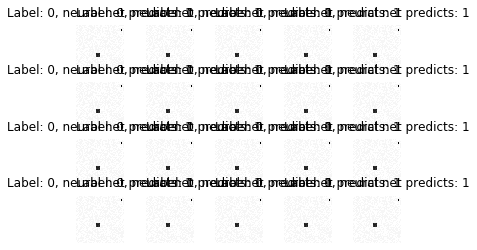

In [80]:
    grid_x = 5
    grid_y = 4
    data_size = grid_x*grid_y
    shuffle = False

    if not shuffle:
        perm_order = np.arange(data_size)
    else:
        perm_order = np.random.permutation(data_size)

    plt.figure()
    for i in range(data_size):
        idx = perm_order[i]

        plt.subplot(grid_y, grid_x, i+1)
        plt.matshow(np.reshape(adversarials[idx], [224,224]), cmap = 'gray', fignum=False)
        plt.axis('off')
        plt.title('Label: {}, neural net predicts: {}'.format(int(adv_lab[idx][0]), 1-int(adv_lab[idx][0])))

    plt.show()

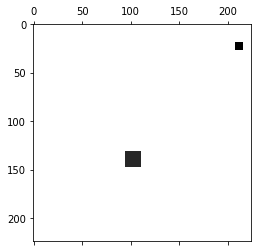

In [81]:
plt.matshow(np.reshape(true_im[0], [224,224]), cmap = 'gray', fignum=False)

In [82]:
model.predict(np.expand_dims(true_im[0], axis=0))

array([[0.32376699]])

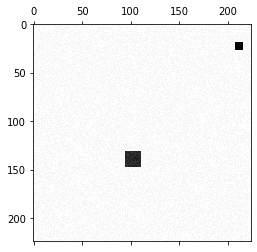

In [83]:
plt.matshow(np.reshape(adversarials[2], [224,224]), cmap = 'gray', fignum=False)

In [ ]:
for i in range(len(adversarials)):
    print(model.predict(adversarials[i]))